In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
import warnings
warnings.filterwarnings('ignore')


In [433]:
from collections import Iterable

from astropy.table import Table
from astropy.time import Time
import numpy as np
import matplotlib.style
import matplotlib as mpl
#mpl.style.use('classic')

import matplotlib.pyplot as plt
import pandas as pd
#plt.rcParams['figure.figsize'] = [15, 15]
#size=18
#params = {'legend.fontsize': size,
#          'figure.figsize': (20,8),
#          'axes.labelsize': size,
#          'axes.titlesize': size,
#          'xtick.labelsize': size*0.75,
#          'ytick.labelsize': size*0.75,
#          'axes.titlepad': 25}
#plt.rcParams.update(params)

mpl.rcParams['figure.figsize'] = [9., 9.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100

mpl.rcParams['font.size'] = '12'
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'

In [3]:
from jetset.model_parameters import ModelParameterArray, ModelParameter
from jetset.analytical_model import AnalyticalParameter
from jetset.base_model import Model
from jetset.model_manager import FitModel
from jetset.minimizer import fit_SED

In [4]:
class GrowthModel(Model):
    """
    Class to handle function for growth model
    """
    
    def __init__(self,nu_size=100,**keywords):
        """
        """
     
        super(GrowthModel,self).__init__(  **keywords)
        self.name='GrowthModel'
        self.parameters = ModelParameterArray()      
        
        self.eta=1
        self.parameters.add_par(AnalyticalParameter(self,name='eta',par_type='',val=1,val_min=0,val_max=None,units=''))        
        self.R0=1
        self.parameters.add_par(AnalyticalParameter(self,name='R0',par_type='',val=1,val_min=0.,val_max=None,units=''))       
        self.tau=1
        self.parameters.add_par(AnalyticalParameter(self,name='tau',par_type='',val=1,val_min=0.,val_max=None,units=''))
        self.t_0=1
        self.parameters.add_par(AnalyticalParameter(self,name='t_0',par_type='',val=1,val_min=-30.,val_max=None,units=''))
    
    def set(self,**keywords):
        super(GrowthMode,self).set(**keywords )

        """
        sets a parameter value checking for physical boundaries 
        """
        if 'val' in keywords.keys():
            self.assign_val(self.name,keywords['val']) 

    def assign_val(self,name,val):
        setattr(self.polymodel,name,val)
    
    #def lin_func(self,nu):        
    #    return -np.log10(self.eta) +(np.log10(self.R0)/self.tau)*(nu-self.eta)
    
    def lin_func(self,nu):
        return (1.0/self.eta)*np.power(self.R0,((nu-self.t_0)/self.tau))
    

In [5]:
class ExpModel(Model):
    """
    Class to handle function for growth model
    """
    
    def __init__(self,nu_size=100,**keywords):
        """
        """
     
        super(ExpModel,self).__init__(  **keywords)
        self.name='Exponential'
        self.parameters = ModelParameterArray()      
        self.R0=1
        self.parameters.add_par(AnalyticalParameter(self,name='R0',par_type='',val=1,val_min=0,val_max=None,units=''))        
        self.tau=1
        self.parameters.add_par(AnalyticalParameter(self,name='tau',par_type='',val=1,val_min=0.,val_max=None,units=''))
        self.t_0=1
        self.parameters.add_par(AnalyticalParameter(self,name='t_0',par_type='',val=1,val_min=-40.,val_max=None,units=''))
    
    def set(self,**keywords):
        super(GrowthMode,self).set(**keywords )

        """
        sets a parameter value checking for physical boundaries 
        """
        if 'val' in keywords.keys():
            self.assign_val(self.name,keywords['val']) 

    def assign_val(self,name,val):
        setattr(self.polymodel,name,val)
    
    #def lin_func(self,nu):        
    #    return -np.log10(self.eta) +(np.log10(self.R0)/self.tau)*(nu-self.eta)
    
    def lin_func(self,nu):
        return np.power(self.R0,((nu-self.t_0)/self.tau))
    

In [6]:
class LogisticPDFModel(Model):
    """
    Class to handle function for growth model
    """
    
    def __init__(self,nu_size=100,**keywords):
        """
        """
     
        super(LogisticPDFModel,self).__init__(  **keywords)
        self.name='LogisticPDFModel'
        self.parameters = ModelParameterArray()      
        self.N=1
        self.parameters.add_par(AnalyticalParameter(self,name='N',par_type='',val=1,val_min=0,val_max=None,units=''))        
        self.tau=1
        self.parameters.add_par(AnalyticalParameter(self,name='tau',par_type='',val=1,val_min=0.,val_max=None,units=''))
        self.t_0=1
        self.parameters.add_par(AnalyticalParameter(self,name='t_0',par_type='',val=0,val_min=None,val_max=None,units=''))
    
    def set(self,**keywords):
        super(GrowthMode,self).set(**keywords )

        """
        sets a parameter value checking for physical boundaries 
        """
        if 'val' in keywords.keys():
            self.assign_val(self.name,keywords['val']) 

    def assign_val(self,name,val):
        setattr(self.polymodel,name,val)
    
    #def lin_func(self,nu):        
    #    return -np.log10(self.eta) +(np.log10(self.R0)/self.tau)*(nu-self.eta)
    
    def lin_func(self,nu):
        y=np.exp(-(nu-self.t_0)/self.tau)
        return (y*self.N/self.tau)/(1+y)**2
    

In [7]:
class Gompertz(Model):
    """
    Class to handle function for growth model
    """
   
    
    def __init__(self,nu_size=100,**keywords):
        """
        """
     
        super(Gompertz,self).__init__(  **keywords)
        self.name='Gompertz'
        self.parameters = ModelParameterArray()      
        self.N=1
        self.parameters.add_par(AnalyticalParameter(self,name='N',par_type='',val=1,val_min=0,val_max=None,units=''))        
        self.t_0=1
        self.parameters.add_par(AnalyticalParameter(self,name='t_0',par_type='',val=0,val_min=-30,val_max=None,units=''))
        self.tau=1
        self.parameters.add_par(AnalyticalParameter(self,name='tau',par_type='',val=1,val_min=0,val_max=None,units=''))
    
    def set(self,**keywords):
        super(GrowthMode,self).set(**keywords )

        """
        sets a parameter value checking for physical boundaries 
        """
        if 'val' in keywords.keys():
            self.assign_val(self.name,keywords['val']) 

    def assign_val(self,name,val):
        setattr(self.polymodel,name,val)
    
    #def lin_func(self,nu):        
    #    return -np.log10(self.eta) +(np.log10(self.R0)/self.tau)*(nu-self.eta)
    
    def lin_func(self,nu):
        y= -self.t_0*np.exp(-nu/self.tau)
        return np.exp(y)*self.N
    

In [8]:
class LogisticModel(Model):
    """
    Class to handle function for growth model
    """
    
    def __init__(self,nu_size=100,**keywords):
        """
        """
     
        super(LogisticModel,self).__init__(  **keywords)
        self.name='LogisticModel'
        self.parameters = ModelParameterArray()      
        self.N=1
        self.parameters.add_par(AnalyticalParameter(self,name='N',par_type='',val=1,val_min=0,val_max=None,units=''))        
        self.tau=1
        self.parameters.add_par(AnalyticalParameter(self,name='tau',par_type='',val=1,val_min=0.,val_max=None,units=''))
        self.t_0=1
        self.parameters.add_par(AnalyticalParameter(self,name='t_0',par_type='',val=0,val_min=-30.,val_max=None,units=''))
    
    def set(self,**keywords):
        super(GrowthMode,self).set(**keywords )

        """
        sets a parameter value checking for physical boundaries 
        """
        if 'val' in keywords.keys():
            self.assign_val(self.name,keywords['val']) 

    def assign_val(self,name,val):
        setattr(self.polymodel,name,val)
    
    #def lin_func(self,nu):        
    #    return -np.log10(self.eta) +(np.log10(self.R0)/self.tau)*(nu-self.eta)
    
    def lin_func(self,nu):
        return self.N/(1+np.exp(-(nu-self.t_0)/self.tau))
    

In [9]:
class Data(object):
    
    def __init__(self,data,time):
        self.data=data
        self.time=time

In [80]:
def get_data_jh(name='Confirmed',country='Italy',fake_error=False):
    """
    name= Confirmed, Deaths, Recovered
    """
    table=Table.read('COVID-19-JH/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-%s.csv'%name)
    ts=table[table['Country/Region']==country]
    df=ts.to_pandas()
    
    y=df.values
    y=y.flatten()[4:].astype(np.int)
    t=df.columns[4:]
    msk=y>0
    
    #to get each time integer from 1 to N (rather than 0 N-1)
    #dates start from 1 not 0
    time=np.arange(1,len(t)+1)
    t=t[msk]
    if fake_error is False:
        y_err= np.sqrt(y[msk])
    else:
        y_err= np.ones(y[msk].size)*0.0001
        
    data_table=Table([time[msk], y[msk], y_err, np.zeros(len(y[msk]),dtype=np.bool )],names=['nu_data','nuFnu_data','dnuFnu_data','UL'])
    data=Data(data_table,pd.to_datetime(t,format='%m/%d/%y').date)
    return data,df

def get_data_protezione_civile(name='deceduti',fake_error=False,regione=None,exclude=False):
    if regione is None:
        table=Table.read('COVID-19-PROTEZIONECIVILE/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv')
        df=table.to_pandas()
        #df[name]=df[name].astype(int)
    else:
        if isinstance(regione,Iterable):
            pass
        else:
            regione=[regione]
        if exclude is True:
            table=Table.read('COVID-19-PROTEZIONECIVILE/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv')
            df_full=table.to_pandas()
            #df_full[name]=df_full[name].astype(int)
            #print('df_full exclude TRue',df_full[name])
        for ID,reg in enumerate(regione):
            table=Table.read('COVID-19-PROTEZIONECIVILE/dati-regioni/dpc-covid19-ita-regioni.csv')
            df=table.to_pandas()
            
            df=df[df['denominazione_regione']==reg]
            df=df.reset_index()
            df[name]=df[name].astype(int)
            #print('df from reading',df[name])
            if exclude is True:
                df_full[name]=df_full[name] -df[name] 
                #print('df_full excldue true in loop',ID,df_full[name])
            else:
                if ID>=1:
                    df[name]=df[name] +df_old 
                else:
                    df_old=df[name] 
                #print('df exclude false in loop',ID,df[name])
            
                
        if exclude is True:
            df=df_full
            #print('df finale exclude True',ID,df[name])
        else:
            #print('df finale exclude False',ID,df[name])
            df=df.reset_index()
    
    t=df['data']
    t=pd.to_datetime(t)
    time=np.arange(1,len(t)+1)
    #print(df[name])
    y=df[name].astype(int)
    #print('y',y)
    msk=y>0
    t=t[msk]
    if fake_error is False:
        y_err= np.sqrt(y[msk])
    else:
        y_err= np.ones(y[msk].size)*0.0001

    data_table=Table([time[msk] , y[msk] , y_err[msk], np.zeros(len(y[msk]),dtype=np.bool )],names=['nu_data','nuFnu_data','dnuFnu_data','UL'])
    data=Data(data_table,np.array(t.dt.date))
    
    y_diff=np.diff(y[msk])
    t_ime_diff=time[msk][1::]
    if fake_error is False:
        y_err_diff= np.sqrt(y_diff)
    else:
        y_err_diff= np.ones(y_diff.size)*0.0001
    data_table_diff=Table([t_ime_diff , y_diff , y_err_diff, np.zeros(len(y_diff),dtype=np.bool )],names=['nu_data','nuFnu_data','dnuFnu_data','UL'])
    t_diff=t[msk][1::]
    
    data_diff=Data(data_table_diff,np.array(t_diff.dt.date))
    return data,data_diff,df


In [11]:
def plot_model(mcmc,model,data,t_start_model=None, t_stop_model=None, size=10,mcmc_samples=500, labels=None,label='',title='',do_derivative=True,y_label='Cumulative Counts'):
    
    fig = plt.figure(constrained_layout=True,figsize=(8,10))
    
    if do_derivative is True:
        widths = [1]
        heights = [1, .2, 1]
        spec = fig.add_gridspec(ncols=1, nrows=3, width_ratios=widths, height_ratios=heights,hspace=0.4)

        ax1 = fig.add_subplot(spec[0])
        ax2 = fig.add_subplot(spec[1],sharex=ax1)
        ax3 = fig.add_subplot(spec[2],sharex=ax2)
    else:
        widths = [1]
        heights = [1, .2,]
        spec = fig.add_gridspec(ncols=1, nrows=2, width_ratios=widths, height_ratios=heights,hspace=0.4)

        ax1 = fig.add_subplot(spec[0])
        ax2 = fig.add_subplot(spec[1],sharex=ax1)
    
    if t_start_model is None:
        t_start_model = model.nu_min_fit
    
    if t_stop_model is None:
        t_stop_model = model.nu_max_fit
        
    nu=np.arange(t_start_model,t_stop_model,1)
    
    if hasattr(model,'GrowthModel'):
        p=np.log10(model.GrowthModel.parameters.R0.best_fit_val)/model.GrowthModel.parameters.tau.val
    
    if mcmc is not None:
        mcmc.reset_to_best_fit()
        y = np.zeros((size,nu.size))

        for ID,ID_rand in enumerate(np.random.randint(len(mcmc.samples), size=mcmc_samples)):
            for ID_par,pi in  enumerate(mcmc.par_array):
                pi.set(val = mcmc.get_par(ID_par)[0][ID_rand])

            y[ID] = model.eval(nu,get_model=True)

        #print(ID)
        y_min=np.amin(y, axis=0)
        y_max=np.amax(y, axis=0)
        ax1.fill_between(nu,y_max,y_min,color='gray',alpha=0.3)

        mcmc.reset_to_best_fit()
    y_bf=model.eval(nu,get_model=True)
    if hasattr(model,'GrowthModel'):
        txt=': Predicted\nlog10(R0)/tau=%3.3f'%p
    else:
        txt=': Predicted'
    ax1.plot(nu,y_bf,label= label+txt)
    
    ax1.errorbar(data.data['nu_data'],data.data['nuFnu_data'],yerr=data.data['dnuFnu_data'],fmt='o',label = label+': Observed')
    
    ax1.axvline(model.nu_min_fit,alpha=0.5)
    ax1.axvline(model.nu_max_fit,alpha=0.5)
    
    
    #set x ticks and lables
    locs, labels = plt.xticks()
    
    #add 100 days to final date in data
    delta_t=pd.date_range(data.time[-1], periods=100, freq='d')[1:]
    t=np.append(data.time,delta_t.date)
    delta_x=data.data['nu_data'][-1]+np.arange(1,len(t)-len(data.data['nu_data'])+1)
   
    #sfit letf by 1 to align time with x thicks 
    x=np.append(data.data['nu_data'],delta_x)
    
    ax1.set_xticks(x[::2])
    ax1.set_xticklabels(t[::2],rotation=90)

    
    ax1.set_ylabel(y_label)
    ax1.semilogy()
     
    ax1.legend(loc='best')
     
    ax1.set_xlim(t_start_model-1,t_stop_model)
    ax1.get_xaxis().set_visible(False)
    
    
    
    x_res,y_res=model.get_residuals(log_log=False,data=data.data)
    msk1 = x_res<model.nu_max_fit
    msk2 =x_res>model.nu_min_fit
    x_res=x_res[msk1*msk2]
    y_res=y_res[msk1*msk2]
    line = ax2.errorbar(x_res, y_res, yerr=np.ones(x_res.size), fmt='+')
    ax2.axhline(0,ls='--',alpha=0.5)
    
    ax2.set_xticks(x[::2])
    ax2.set_xticklabels(t[::2],rotation=90)
    ax2.set_xlim(t_start_model-1,t_stop_model)
    #ax2.set_xticklabels(t,rotation=45)
    #plt.setp(ax2.get_xticklabels(), ha="right", rotation=90)
    
    #Derivative
    if do_derivative is True:
        ax3.plot(nu  ,np.gradient(y_bf,nu,edge_order=2 ),label='model')

        if mcmc is not None:
            y_der = np.zeros((size,nu.size))
            for ID,ID_rand in enumerate(np.random.randint(len(mcmc.samples), size=mcmc_samples)):
                for ID_par,pi in  enumerate(mcmc.par_array):
                    pi.set(val = mcmc.get_par(ID_par)[0][ID_rand])
                y[ID] = model.eval(nu,get_model=True)
                y_der[ID] = np.gradient(y[ID],nu,edge_order=2) 

            y_min=np.amin(y_der, axis=0)
            y_max=np.amax(y_der, axis=0)    
            ax3.fill_between(nu ,y_max  ,y_min  ,color='gray',alpha=0.3)

        ax3.plot(data.data['nu_data']  ,np.gradient(data.data['nuFnu_data'],data.data['nu_data']),'o',label='data')

        ax3.axvline(model.nu_min_fit,alpha=0.5)
        ax3.axvline(model.nu_max_fit,alpha=0.5)    
        ax3.semilogy()
        ax3.set_xticks(x[::2])
        ax3.set_xticklabels(t[::2],rotation=90)
        ax3.set_xlabel('date')
        ax3.set_ylabel('derivative of %s'%y_label)
        ax3.set_xlim(t_start_model-1,t_stop_model)
        ax3.legend(loc='best')
        plt.tight_layout()
        fig.suptitle(title,y=1.02)
    
    
    #plt.subplots_adjust(hspace=.0)
    return fig

In [12]:
from jetset.minimizer import fit_SED
from jetset.mcmc import McmcSampler


In [13]:
def do_analysis(model,data,t_start,t_stop,t_start_model,t_stop_model,name,do_plot=True,do_mcmc=True,mcmc_steps=500,title='',do_derivative=True):


    model.nu_min=0
    model.nu_max=100
    
    
    fm=FitModel(analytical=model,name='test')
    bfm,mm=fit_SED(fm,data,nu_fit_start=t_start,nu_fit_stop=t_stop,minimizer='minuit',silent=True)
    
    if hasattr(model,'R0'):
        log_R0_by_tau=np.log10(model.parameters.R0.val)/model.parameters.tau.val
        print('log10(R0)/tau',log_R0_by_tau)
        print('doubling time',np.log10(2)/log_R0_by_tau)

    bfm.fit_Model.show_best_fit_pars()
    if do_mcmc is True:
        mcmc=McmcSampler(bfm)
        mcmc.run_sampler(nwalkers=150,burnin=10,steps=mcmc_steps,bound=2,bound_rel=True,walker_start_bound=0.001,threads=1)
        print('bounds',mcmc._bounds)
    else:
        mcmc = None
    if do_plot is True:
        fig=plot_model(mcmc,bfm.fit_Model,data,t_start_model=t_start,t_stop_model= t_stop_model,label=name,size=100,mcmc_samples=100,title=title,do_derivative=do_derivative)
            
        
        
        
        

    return bfm,mm,mcmc,data,fig

# Model fitting

## Logistic

  1%|          | 6/500 [00:00<00:09, 51.76it/s]

  model name  name bestfit val     err +     err -  start val   fit range min fit range max frozen
------------- ---- ------------ ------------ ----- ------------ ------------- ------------- ------
LogisticModel    N 4.455735e+03 2.086360e+02    -- 1.000000e+00  0.000000e+00            --  False
LogisticModel  tau 3.257754e+00 5.499657e-02    -- 1.000000e+00  0.000000e+00            --  False
LogisticModel  t_0 2.208819e+01 2.946968e-01    -- 0.000000e+00 -3.000000e+01            --  False
mcmc run starting


100%|██████████| 500/500 [00:09<00:00, 51.14it/s]


mcmc run done, with 1 threads took 9.81 seconds
bounds [[0, 13367.203511109876], [0.0, 9.77326130195637], [-22.088191357477207, 66.26457407243163]]

**************************************************************************************************
Fit report

Model: None
  model name  name par type units     val      phys. bound. min phys. bound. max  log  frozen
------------- ---- -------- ----- ------------ ---------------- ---------------- ----- ------
LogisticModel    N                4.464004e+03     0.000000e+00               -- False  False
LogisticModel  tau                3.260388e+00     0.000000e+00               -- False  False
LogisticModel  t_0                2.213990e+01    -3.000000e+01               -- False  False

converged=True
calls=232
------------------------------------------------------------------
| FCN = 28.32                   |     Ncalls=231 (231 total)     |
| EDM = 2.32E-07 (Goal: 1E-05)  |            up = 1.0            |
-------------------------------

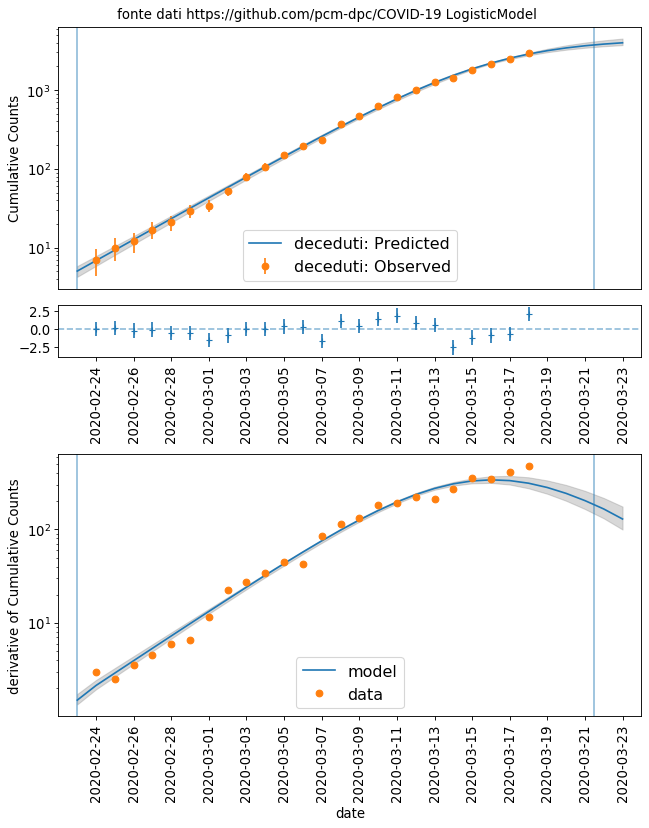

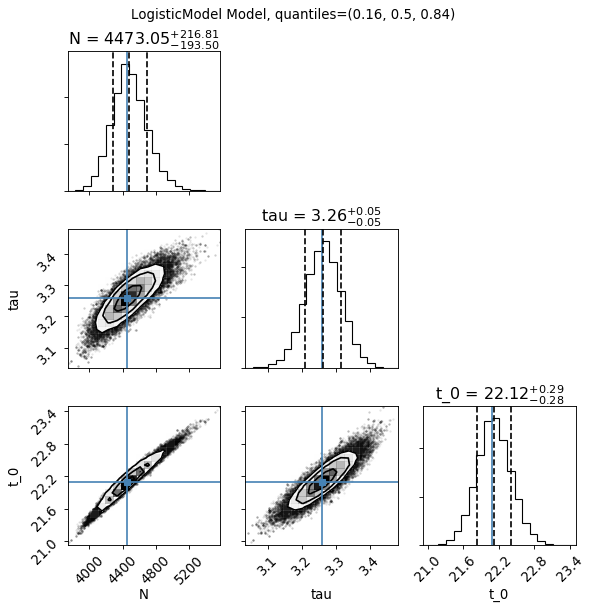

In [294]:
name='deceduti'
data,data_diff,df =get_data_protezione_civile(name,fake_error=False,exclude=False)
model=LogisticModel()
#model.parameters.t_0.val=-2
#model.parameters.tau.val=2

bfm,mm,mcmc,data,fig=do_analysis(model,
                                 data,
                                 t_start=0,
                                 t_stop=27.5,
                                 t_start_model=0,
                                 t_stop_model=30,
                                 name=name,
                                 mcmc_steps=500,
                                 title=' fonte dati https://github.com/pcm-dpc/COVID-19 %s'%model.name,
                                 do_mcmc=True,
                                 do_derivative=True)
if mcmc is not None:
    f=mcmc.corner_plot(quantiles=(0.16,0.5,0.84))
    f.suptitle('%s Model, quantiles=%s '%(model.name,str((0.16,0.5,0.84))),y=1.01)

plt.tight_layout()
print(mm.show_report())

## Exponential

 12%|█▏        | 6/50 [00:00<00:00, 56.83it/s]

log10(R0)/tau 0.11009975228015263
doubling time 2.7341568843679136
 model name name  bestfit val     err +     err -  start val   fit range min fit range max frozen
----------- ---- ------------- ------------ ----- ------------ ------------- ------------- ------
Exponential   R0  1.887903e+00 3.715913e-01    -- 2.800000e+00  0.000000e+00            --  False
Exponential  tau  2.506634e+00 7.690509e-01    -- 1.000000e+00  0.000000e+00            --  False
Exponential  t_0 -8.729404e+00 2.538225e-01    -- 1.000000e+00 -4.000000e+01            --  False
mcmc run starting


100%|██████████| 50/50 [00:00<00:00, 53.35it/s]


mcmc run done, with 1 threads took 0.96 seconds
bounds [[0, 5.663710180570619], [0.0, 7.519901581991623], [-26.188211228120082, 8.729403742706694]]



**************************************************************************************************
Fit report

Model: None
 model name name par type units      val      phys. bound. min phys. bound. max  log  frozen
----------- ---- -------- ----- ------------- ---------------- ---------------- ----- ------
Exponential   R0                 1.934102e+00     0.000000e+00               -- False  False
Exponential  tau                 2.608043e+00     0.000000e+00               -- False  False
Exponential  t_0                -8.843440e+00    -4.000000e+01               -- False  False

converged=True
calls=281
------------------------------------------------------------------
| FCN = 169.8                   |     Ncalls=280 (280 total)     |
| EDM = 2.08E-06 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
--------------------------------------------------

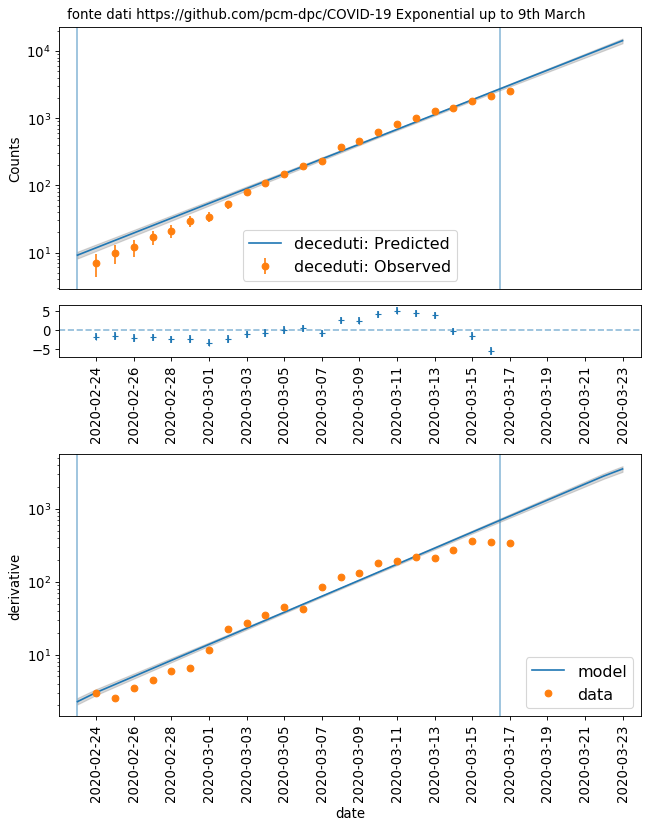

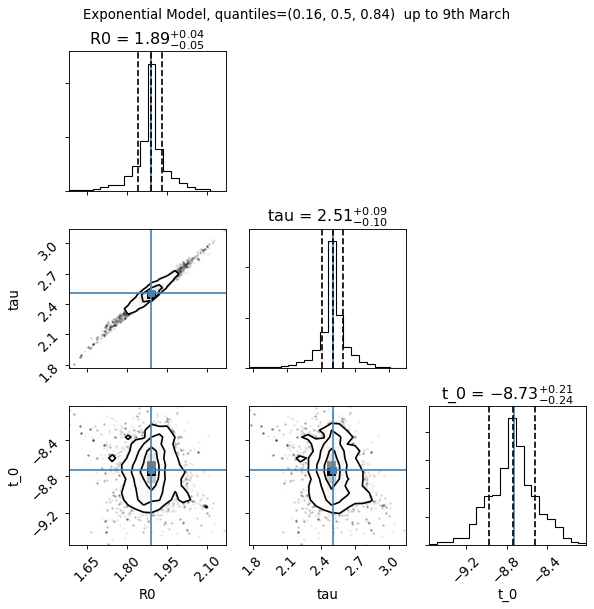

In [137]:
name='deceduti'
data,data_diff,df =get_data_protezione_civile(name,fake_error=False)
model=ExpModel()
model.parameters.R0.val=2.8
bfm,mm,mcmc,data,fig=do_analysis(model,data,t_start=0,t_stop=22.5,t_start_model=0,t_stop_model=30,name=name,mcmc_steps=50,title=' fonte dati https://github.com/pcm-dpc/COVID-19 %s up to 9th March'%model.name,do_mcmc=True)
f=mcmc.corner_plot(quantiles=(0.16,0.5,0.84))
f.suptitle('%s Model, quantiles=%s '%(model.name,str((0.16,0.5,0.84))),y=1.01)
plt.tight_layout()
print(mm.show_report())

## Gompertz Model

  1%|          | 6/500 [00:00<00:09, 50.18it/s]

model name name bestfit val     err +     err -  start val   fit range min fit range max frozen
---------- ---- ------------ ------------ ----- ------------ ------------- ------------- ------
  Gompertz    N 6.554973e+04 1.835247e+04    -- 1.000000e+00  0.000000e+00            --  False
  Gompertz  t_0 1.071830e+01 1.307435e-01    -- 0.000000e+00 -3.000000e+01            --  False
  Gompertz  tau 1.926001e+01 1.237913e+00    -- 1.000000e+00  0.000000e+00            --  False
mcmc run starting


100%|██████████| 500/500 [00:09<00:00, 53.25it/s]


mcmc run done, with 1 threads took 9.41 seconds
bounds [[0, 196649.19717255805], [-10.718299429527455, 32.154898288582366], [0, 57.780037148784274]]


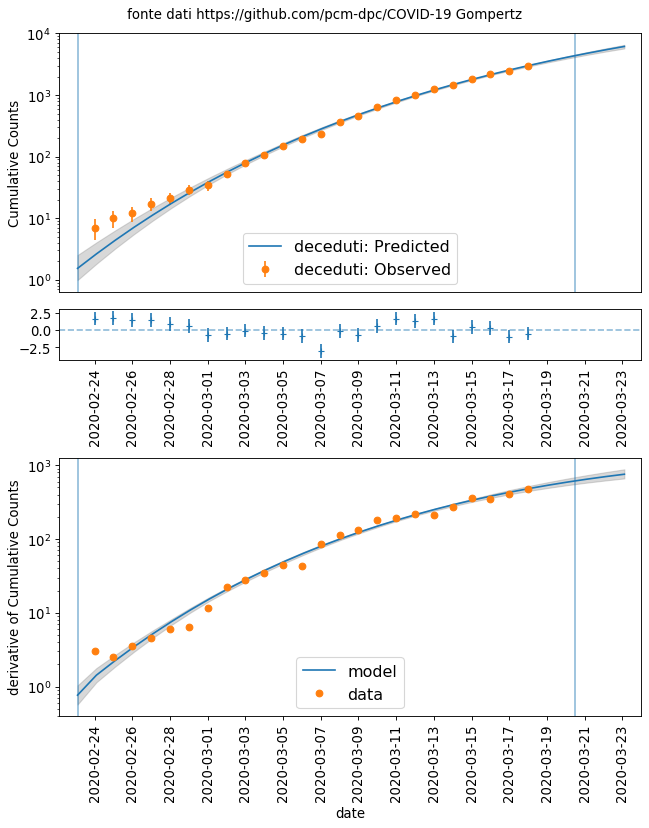

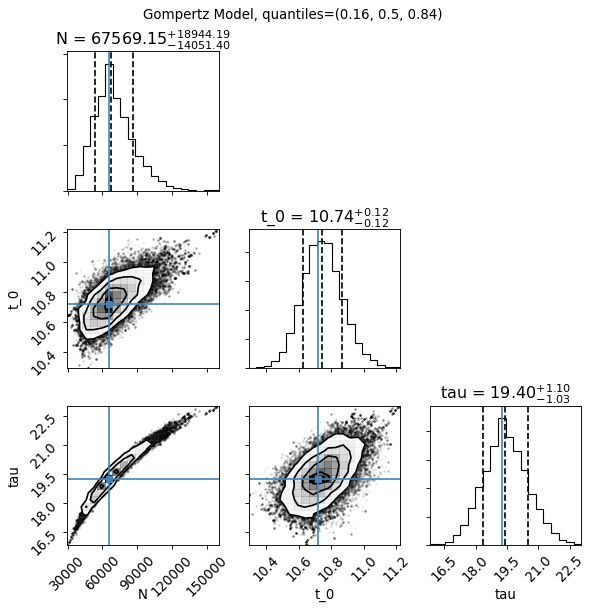

In [99]:
name='deceduti'
data,data_diff,df =get_data_protezione_civile(name,fake_error=False)
model=Gompertz()
bfm,mm,mcmc,data,fig=do_analysis(model,data,t_start=0.1,t_stop=26.5,t_start_model=0.1,t_stop_model=30,name=name,mcmc_steps=500,title=' fonte dati https://github.com/pcm-dpc/COVID-19 %s '%model.name,do_mcmc=True)
f=mcmc.corner_plot(quantiles=(0.16,0.5,0.84))
f.suptitle('%s Model, quantiles=%s '%(model.name,str((0.16,0.5,0.84))),y=1.01)
plt.tight_layout()
#print(mm.show_report())
#print(np.sum(~np.isfinite(mcmc.samples_log_prob)))

  1%|          | 6/500 [00:00<00:09, 52.48it/s]

model name name bestfit val     err +     err -  start val   fit range min fit range max frozen
---------- ---- ------------ ------------ ----- ------------ ------------- ------------- ------
  Gompertz    N 8.672514e+03 1.016700e+03    -- 1.000000e+00  0.000000e+00            --  False
  Gompertz  t_0 6.574284e+00 7.036658e-02    -- 0.000000e+00 -3.000000e+01            --  False
  Gompertz  tau 1.514280e+01 7.322519e-01    -- 1.000000e+00  0.000000e+00            --  False
mcmc run starting


100%|██████████| 500/500 [00:09<00:00, 53.81it/s]


mcmc run done, with 1 threads took 9.32 seconds
bounds [[0, 26017.54061856651], [-6.574284475597551, 19.722853426792653], [0, 45.42840967730971]]


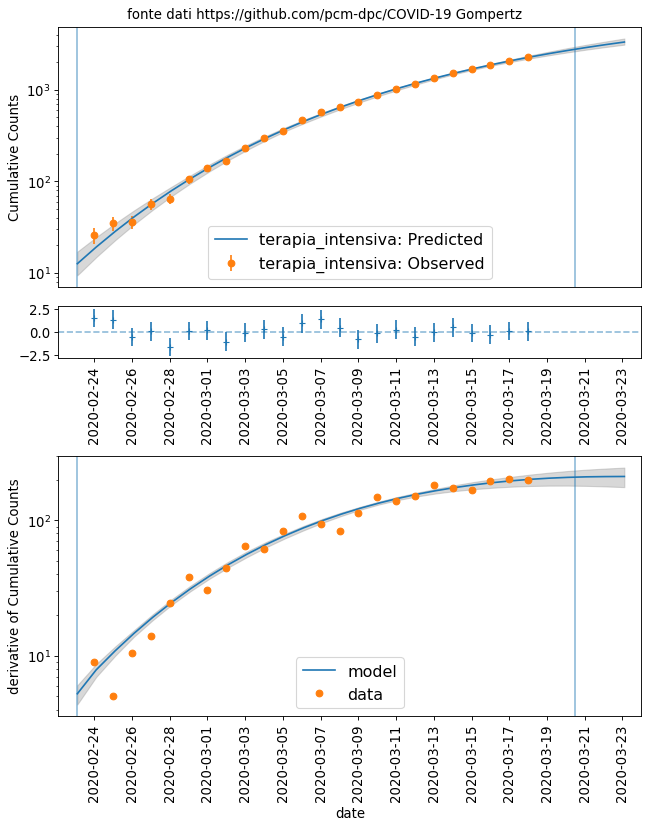

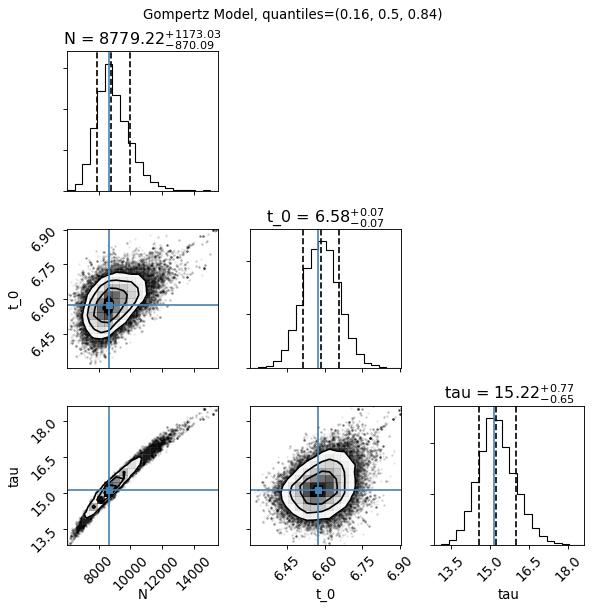

In [100]:

name='terapia_intensiva'
data,data_diff,df =get_data_protezione_civile(name,fake_error=False)
model=Gompertz()
bfm,mm,mcmc,data,fig=do_analysis(model,data,t_start=0.1,t_stop=26.5,t_start_model=0.1,t_stop_model=30,name=name,mcmc_steps=500,title=' fonte dati https://github.com/pcm-dpc/COVID-19 %s '%model.name,do_mcmc=True)
f=mcmc.corner_plot(quantiles=(0.16,0.5,0.84))
f.suptitle('%s Model, quantiles=%s '%(model.name,str((0.16,0.5,0.84))),y=1.01)
plt.tight_layout()
#print(mm.show_report())
#print(np.sum(~np.isfinite(mcmc.samples_log_prob)))

In [16]:
def running_mean_uniform_filter1d(x, N):
    return ndif.uniform_filter1d(x, N, mode='constant', origin=-(N//2))[:-(N-1)]

In [117]:

def plot_ratio(name,plot_vline=False,delta=5,po_ratio=1.2,gradient=True,running_mean_window=1,regioni=['Lombardia','Piemonte','Veneto','Emilia Romagna']):
    
    fig = plt.figure(figsize=(18,9))
    ax1=fig.add_subplot(1, 2, 1)   #top and bottom left
    ax2=fig.add_subplot(1, 2, 2)
    data_i,data_diff,df_i =get_data_protezione_civile(name,fake_error=False)
    df_i['data']=pd.to_datetime(df_i['data'])
    x=df_i['data'].array
    y_i=df_i[name].array
    
    data,data_diff,df_n =get_data_protezione_civile(name,fake_error=False,regione=regioni,exclude=False)
    data,data_diff,df_r =get_data_protezione_civile(name,fake_error=False,regione=regioni,exclude=True)
    y_n= df_n[name].array 
    y_r= df_r[name].array 
    
    
    if running_mean_window >1:
        y_n=running_mean_uniform_filter1d(y_n,running_mean_window)
        y_r=running_mean_uniform_filter1d(y_r,running_mean_window)
        #print(len(x))
        x=x[:-(running_mean_window-1)]
        #print(len(x),len(y_r),running_mean_window)
    
    for ID,ax in enumerate([ax1,ax2]):
        if ID==0:
            y_i= np.array(y_i)
            y_n= np.array(y_n)
            y_r= np.array(y_r)
        else:
            if gradient is True:
                y_i=np.gradient(np.array(y_i),edge_order=2)
                y_n=np.gradient(np.array(y_n),edge_order=2)
                y_r=np.gradient(np.array(y_r),edge_order=2)
            else:
                y_i=np.diff(np.array(y_i) )
                y_n=np.diff(np.array(y_n) )
                y_r=np.diff(np.array(y_r) )
                x=x[1:]
               
        ax.plot(np.array(x),y_n ,'-o',label='North')
        ax.plot(np.array(x),y_r*po_ratio ,'-o',label='(Italy-North)*%1.1f'%po_ratio)

        if plot_vline is True:
            ax.axvline(df_i['data'][12],ls='--',c='r',label='north to south massive migration')
            ax.axvline(df_i['data'][14],ls='--',c='y',label='north lockdown')
    


        df_i['data'] =df_i['data'] + pd.DateOffset(days=-delta)
        dx=df_i['data']
        #x=np.array(x)
        ax.plot(np.array(x),y_r*po_ratio ,'-o',label='(Italy-North)*%1.1f shifted %1.1f days'%(po_ratio,delta))
        ax.semilogy()
        #ax.semilogx()
        #name='deaths'
        if ID==0:
            ax.set_ylabel('counts Cumulative')
        else:
            ax.set_ylabel('counts')

        ax.legend(loc='best',fontsize=12)
        ax.set_title('%s\nNorth= Lombardia, Piemonte, Veneto , Emilia Romagna'%name )
        plt.draw()
        ax.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
        
        
        

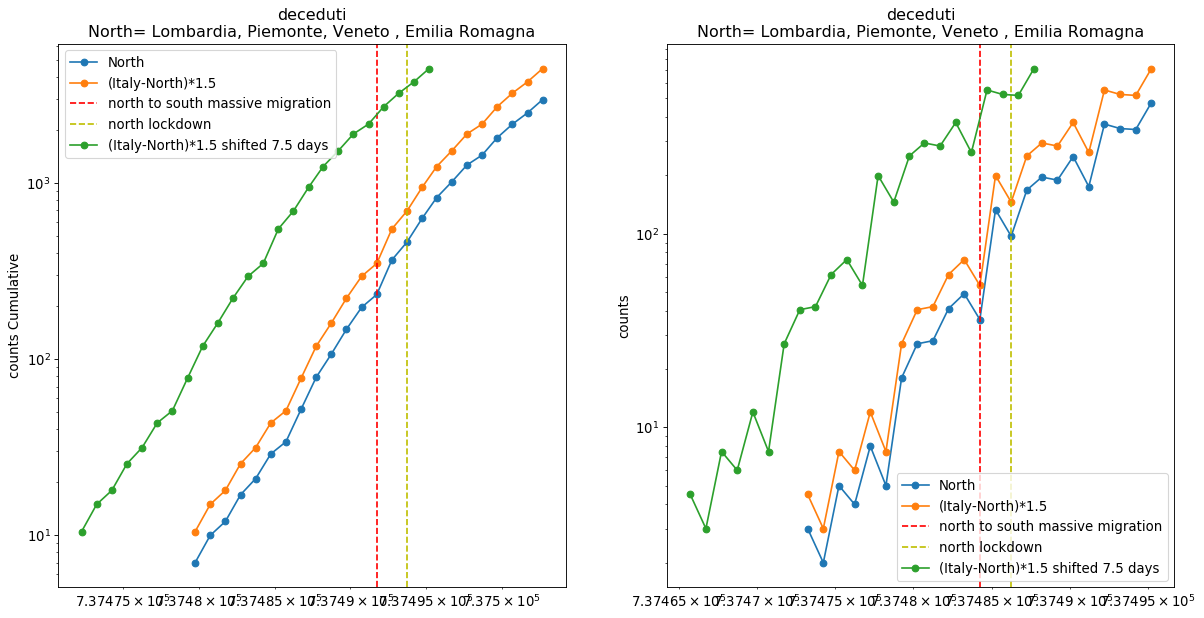

In [114]:
plot_ratio('deceduti',plot_vline=True,delta=7.5,po_ratio=1.5,gradient=False,running_mean_window=0,regioni=None)

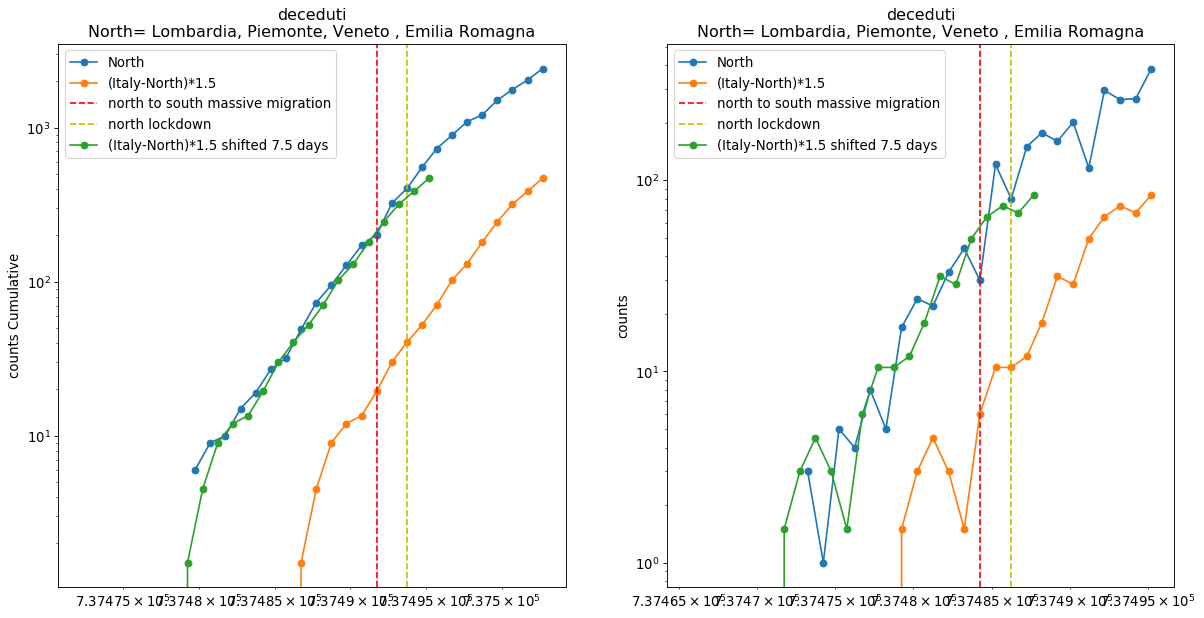

In [115]:
plot_ratio('deceduti',plot_vline=True,delta=7.5,po_ratio=1.5,gradient=False,running_mean_window=0)
#plot_ratio('deceduti',plot_vline=True,delta=7.5,po_ratio=1.5,gradient=True,running_mean_window=0)


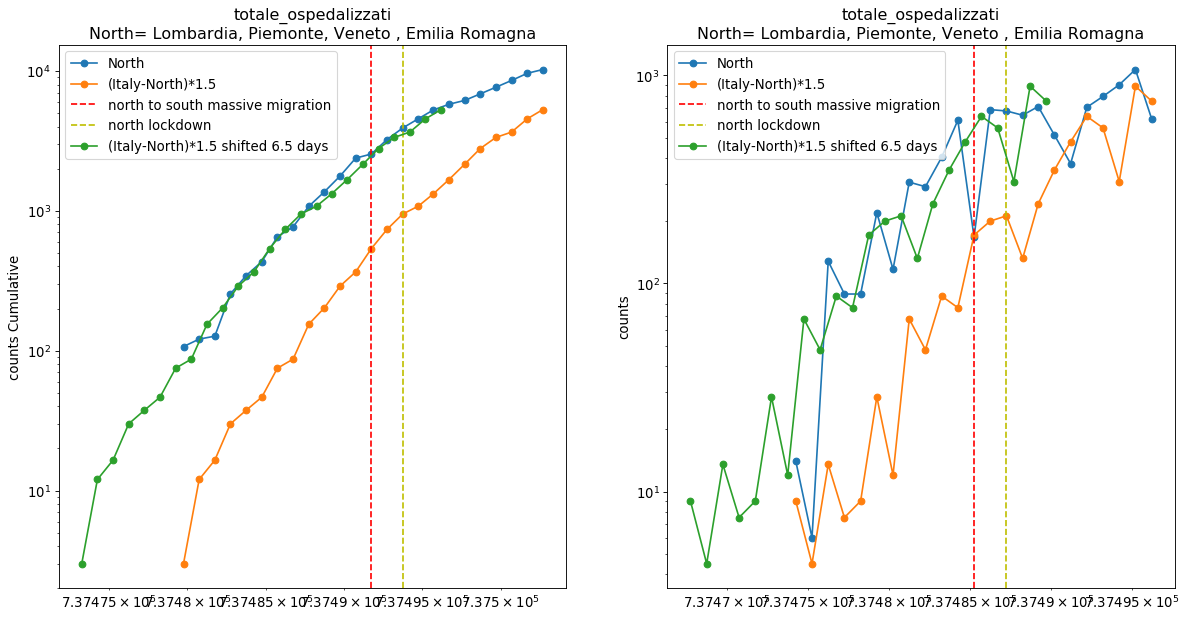

In [116]:
plot_ratio('totale_ospedalizzati',plot_vline=True,delta=6.5,po_ratio=1.5,gradient=False,running_mean_window=0)


In [309]:
from scipy.stats import logistic, genlogistic 
from scipy.stats import lognorm

(18.602711317609963, 7.777430877518453, 3.752398947146111, 109.53929820506681)

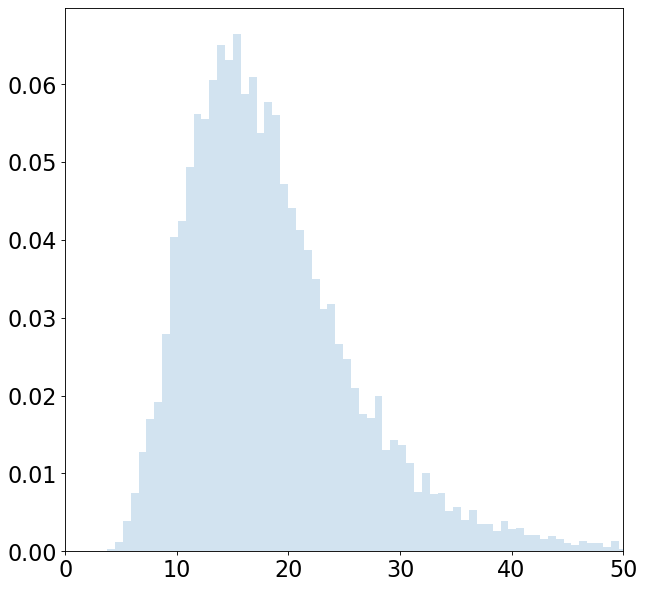

In [427]:
r = logistic.rvs(size=10000,scale=3,loc=20)
l = lognorm.rvs(s=0.4,scale=17.2,loc=0,size=10000)
plt.hist(l, density=True, histtype='stepfilled', alpha=0.2,bins=150)
plt.xlim(0,50)
l.mean(),l.std(),l.min(),l.max()

In [428]:
x=np.zeros(r.size)

In [429]:
for ID,p in enumerate(r):
    x[ID]=p+l[ID]
    
days=np.linspace(0,69,70)
days

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64.,
       65., 66., 67., 68., 69.])

Text(0.5, 0, 'days')

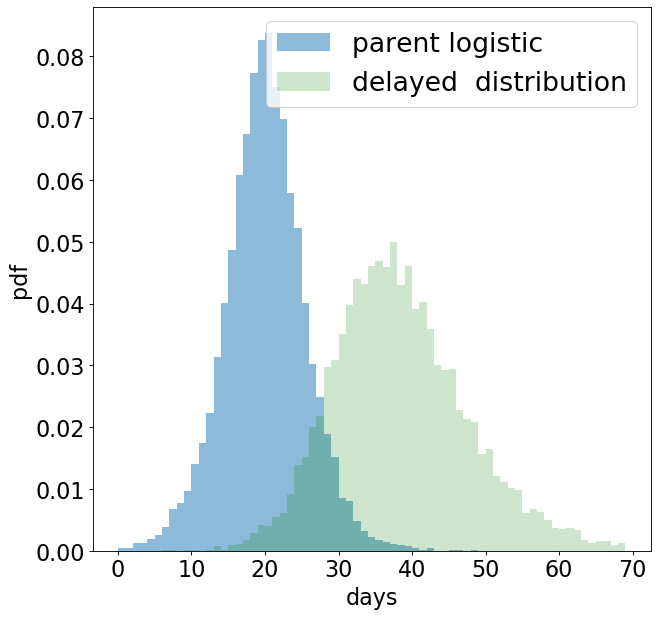

In [430]:
y_l=plt.hist(r,bins=days,density=True, histtype='stepfilled', alpha=0.5,cumulative=False,label='parent logistic')
#plt.hist(l, density=True, histtype='stepfilled', alpha=0.2)
y_d=plt.hist(x,bins=days, density=True, histtype='stepfilled', alpha=0.2,cumulative=False,label='delayed  distribution',color='green')
plt.legend(loc='best')
plt.ylabel('pdf')
plt.xlabel('days')

Text(0.5, 0, 'days')

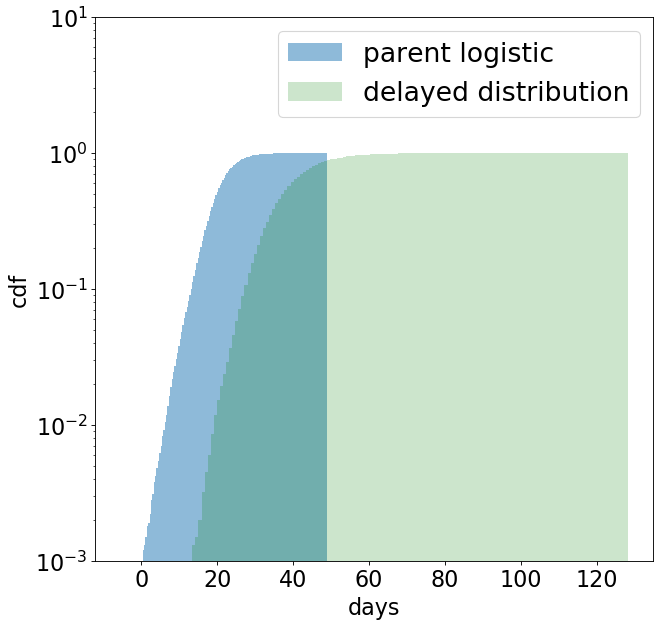

In [431]:
_=plt.hist(r,density=True, histtype='stepfilled', alpha=0.5,cumulative=True,bins=150,label='parent logistic')
#plt.hist(l, density=True, histtype='stepfilled', alpha=0.2)
_=plt.hist(x, density=True, histtype='stepfilled', alpha=0.2,cumulative=True,bins=150,label='delayed distribution',color='green')
plt.legend(loc='best')
plt.ylim(0.001,10)
plt.semilogy()
plt.ylabel('cdf')
plt.xlabel('days')


In [379]:
data_table_diff=Table([days , y_d , np.sqrt(y_d), np.zeros(len(y),dtype=np.bool )],names=['nu_data','nuFnu_data','dnuFnu_data','UL'])

TypeError: loop of ufunc does not support argument 0 of type numpy.ndarray which has no callable sqrt method

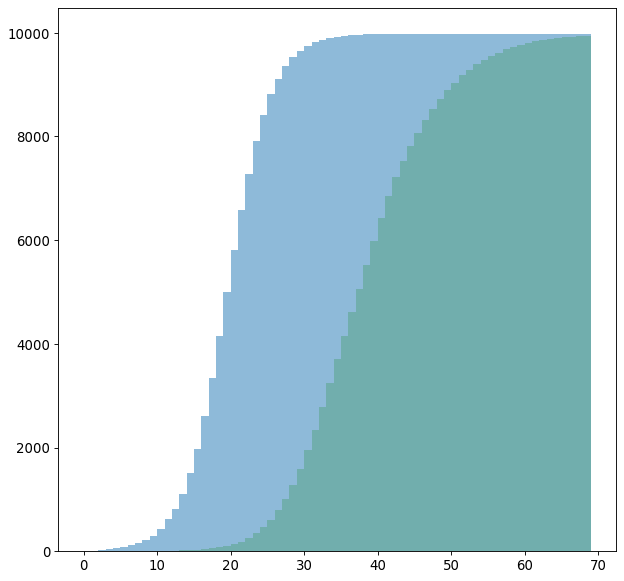

In [396]:
y_l=plt.hist(r,bins=days,density=False, histtype='stepfilled', alpha=0.5,cumulative=True,label='parent logistic')
#plt.hist(l, density=True, histtype='stepfilled', alpha=0.2)
y_d=plt.hist(x,bins=days, density=False, histtype='stepfilled', alpha=0.2,cumulative=True,label='delayed  distribution',color='green')

In [422]:
table_d=Table([days[1:] , y_d[0] , np.sqrt(y_d[0]), np.zeros(len(y_d[0]),dtype=np.bool )],names=['nu_data','nuFnu_data','dnuFnu_data','UL'])
data_delayed=Data(table_d,pd.date_range(start='2/18/2020', periods=69).date)

table_l=Table([days[1:] , y_l[0] , np.sqrt(y_l[0]), np.zeros(len(y_l[0]),dtype=np.bool )],names=['nu_data','nuFnu_data','dnuFnu_data','UL'])
data_logistic=Data(table_l,pd.date_range(start='2/18/2020', periods=69).date)

  1%|          | 6/500 [00:00<00:09, 54.59it/s]

  model name  name bestfit val     err +     err -  start val   fit range min fit range max frozen
------------- ---- ------------ ------------ ----- ------------ ------------- ------------- ------
LogisticModel    N 4.802546e+03 4.084229e+02    -- 1.000000e+00  0.000000e+00            --  False
LogisticModel  tau 3.209246e+00 6.262985e-02    -- 1.000000e+00  0.000000e+00            --  False
LogisticModel  t_0 3.221744e+01 4.553000e-01    -- 0.000000e+00 -3.000000e+01            --  False
mcmc run starting


100%|██████████| 500/500 [00:09<00:00, 53.75it/s]


mcmc run done, with 1 threads took 9.33 seconds
bounds [[0, 14407.638025575992], [0.0, 9.627738545958213], [-30.0, 96.65233362243816]]

**************************************************************************************************
Fit report

Model: None
  model name  name par type units     val      phys. bound. min phys. bound. max  log  frozen
------------- ---- -------- ----- ------------ ---------------- ---------------- ----- ------
LogisticModel    N                5.069301e+03     0.000000e+00               -- False  False
LogisticModel  tau                3.186036e+00     0.000000e+00               -- False  False
LogisticModel  t_0                3.245127e+01    -3.000000e+01               -- False  False

converged=True
calls=321
------------------------------------------------------------------
| FCN = 4.653                   |     Ncalls=320 (320 total)     |
| EDM = 4.24E-05 (Goal: 1E-05)  |            up = 1.0            |
--------------------------------------------

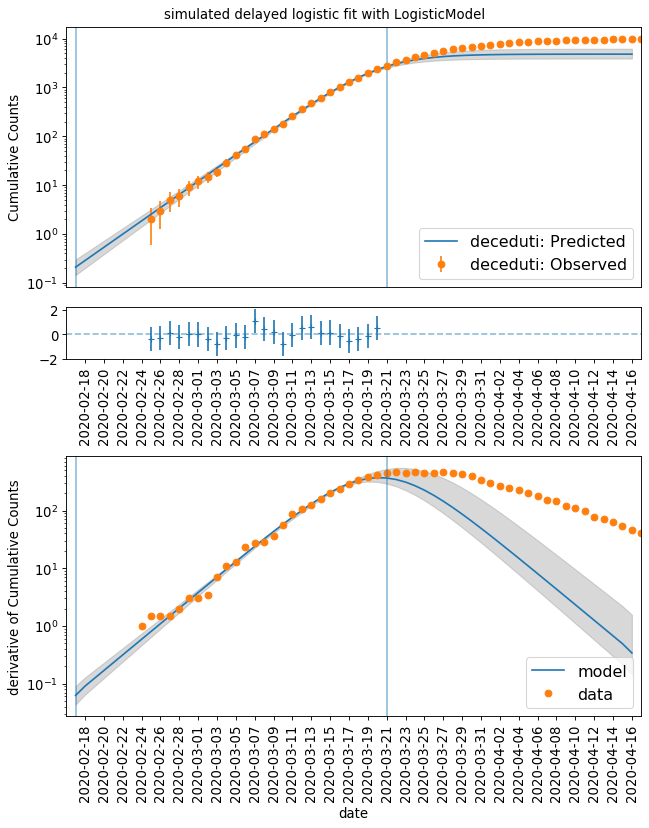

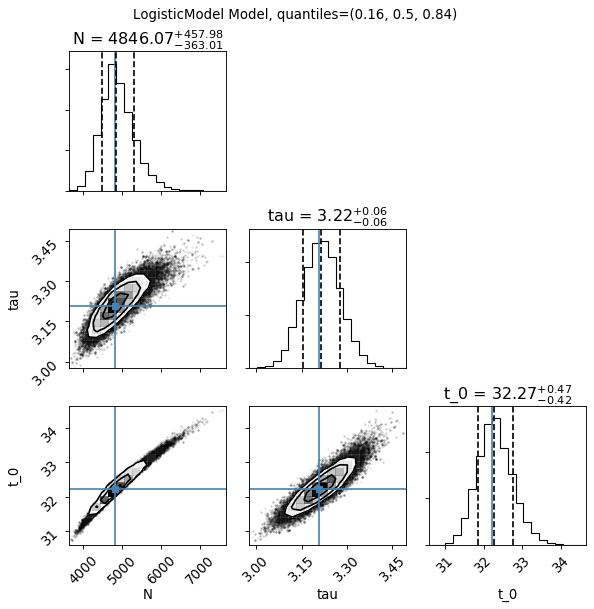

In [439]:
model=LogisticModel()
#model.parameters.t_0.val=-2
#model.parameters.tau.val=2

bfm,mm,mcmc,data,fig=do_analysis(model,
                                 data_delayed,
                                 t_start=0,
                                 t_stop=33,
                                 t_start_model=0,
                                 t_stop_model=60,
                                 name=name,
                                 mcmc_steps=500,
                                 title='simulated delayed logistic fit with %s'%model.name,
                                 do_mcmc=True,
                                 do_derivative=True)
if mcmc is not None:
    f=mcmc.corner_plot(quantiles=(0.16,0.5,0.84))
    f.suptitle('%s Model, quantiles=%s '%(model.name,str((0.16,0.5,0.84))),y=1.01)

plt.tight_layout()
print(mm.show_report())

In [421]:
pd.date_range(start='1/3/2020', periods=69)

DatetimeIndex(['2020-01-03', '2020-01-04', '2020-01-05', '2020-01-06',
               '2020-01-07', '2020-01-08', '2020-01-09', '2020-01-10',
               '2020-01-11', '2020-01-12', '2020-01-13', '2020-01-14',
               '2020-01-15', '2020-01-16', '2020-01-17', '2020-01-18',
               '2020-01-19', '2020-01-20', '2020-01-21', '2020-01-22',
               '2020-01-23', '2020-01-24', '2020-01-25', '2020-01-26',
               '2020-01-27', '2020-01-28', '2020-01-29', '2020-01-30',
               '2020-01-31', '2020-02-01', '2020-02-02', '2020-02-03',
               '2020-02-04', '2020-02-05', '2020-02-06', '2020-02-07',
               '2020-02-08', '2020-02-09', '2020-02-10', '2020-02-11',
               '2020-02-12', '2020-02-13', '2020-02-14', '2020-02-15',
               '2020-02-16', '2020-02-17', '2020-02-18', '2020-02-19',
               '2020-02-20', '2020-02-21', '2020-02-22', '2020-02-23',
               '2020-02-24', '2020-02-25', '2020-02-26', '2020-02-27',
      

  1%|          | 6/500 [00:00<00:08, 57.98it/s]

  model name  name bestfit val     err +     err -  start val   fit range min fit range max frozen
------------- ---- ------------ ------------ ----- ------------ ------------- ------------- ------
LogisticModel    N 9.850472e+03 6.157590e+01    -- 1.000000e+00  0.000000e+00            --  False
LogisticModel  tau 2.858244e+00 2.040669e-02    -- 1.000000e+00  0.000000e+00            --  False
LogisticModel  t_0 1.992124e+01 5.577625e-02    -- 0.000000e+00 -3.000000e+01            --  False
mcmc run starting


100%|██████████| 500/500 [00:09<00:00, 54.15it/s]


mcmc run done, with 1 threads took 9.26 seconds
bounds [[0, 29551.41667562712], [0.0, 8.574733464784636], [-19.921241903763743, 59.76372571129123]]

**************************************************************************************************
Fit report

Model: None
  model name  name par type units     val      phys. bound. min phys. bound. max  log  frozen
------------- ---- -------- ----- ------------ ---------------- ---------------- ----- ------
LogisticModel    N                9.946717e+03     0.000000e+00               -- False  False
LogisticModel  tau                2.864698e+00     0.000000e+00               -- False  False
LogisticModel  t_0                1.997982e+01    -3.000000e+01               -- False  False

converged=True
calls=233
------------------------------------------------------------------
| FCN = 38.23                   |     Ncalls=232 (232 total)     |
| EDM = 2.57E-06 (Goal: 1E-05)  |            up = 1.0            |
-------------------------------

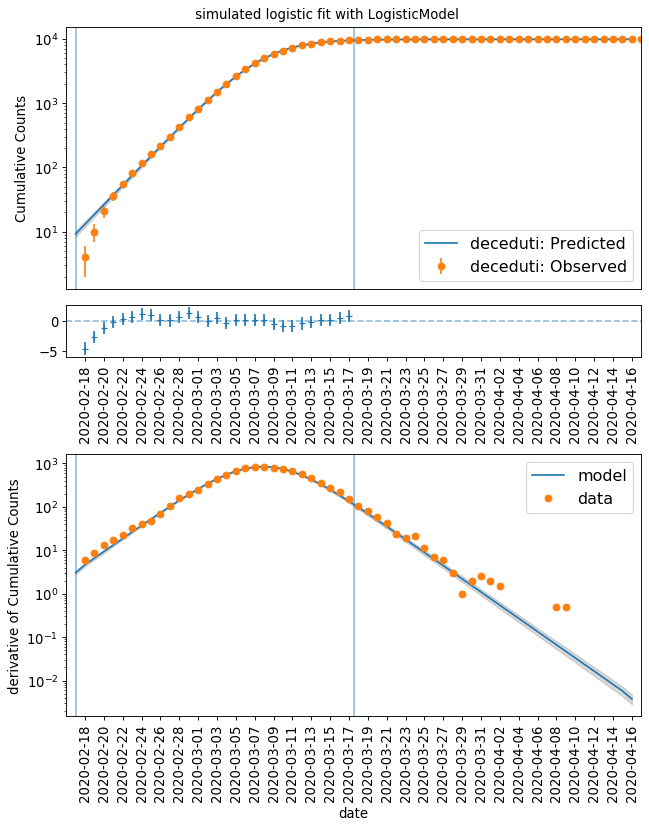

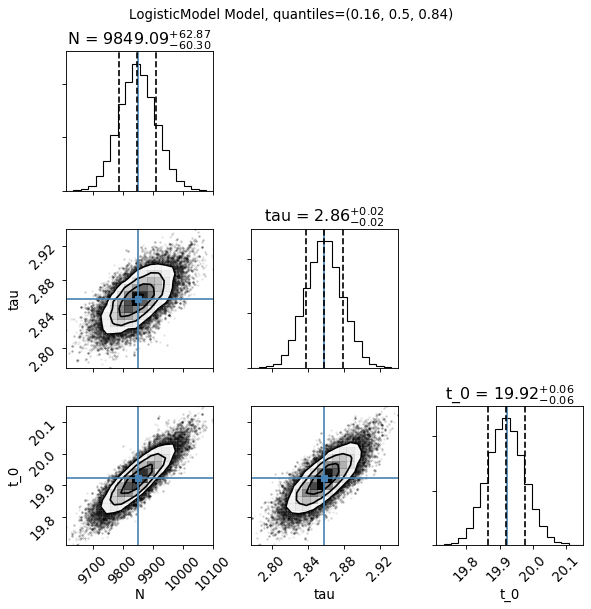

In [437]:
model=LogisticModel()
#model.parameters.t_0.val=-2
#model.parameters.tau.val=2

bfm,mm,mcmc,data,fig=do_analysis(model,
                                 data_logistic,
                                 t_start=0,
                                 t_stop=29.5,
                                 t_start_model=0,
                                 t_stop_model=60,
                                 name=name,
                                 mcmc_steps=500,
                                 title=' simulated logistic fit with %s'%model.name,
                                 do_mcmc=True,
                                 do_derivative=True)
if mcmc is not None:
    f=mcmc.corner_plot(quantiles=(0.16,0.5,0.84))
    f.suptitle('%s Model, quantiles=%s '%(model.name,str((0.16,0.5,0.84))),y=1.01)

plt.tight_layout()
print(mm.show_report())

In [413]:
data_logistic.data['nuFnu_data']

4.0
10.0
21.0
36.0
55.0
81.0
119.0
162.0
214.0
298.0
428.0
